In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
import os
# os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:64"


import pandas as pd
import numpy as np
import torch
import torch_geometric as pyg
from tqdm.auto import *

from smartgd.model import Generator, Discriminator
from smartgd.data import GraphDrawingData
from smartgd.datasets import  RomeDataset
from smartgd.metrics import Stress, Crossings
from smartgd.transformations import Compose, Center, NormalizeRotation, RescaleByStress
from smartgd.criteria import RGANCriterion

In [23]:
device = "cpu"
for backend, device_name in {
    # torch.backends.mps: "mps",
    torch.cuda: "cuda",
}.items():
    if backend.is_available():
        device = device_name
model_name = "stress"
batch_size = 32
start_epoch = 121
max_epoch = 500
max_lr = 0.0008
min_lr = 0.0001
wr_period = 200
train_size = 10000

In [36]:
GraphDrawingData.set_optional_fields([
    "edge_pair_metaindex",
    # "face",
    # "rng"
])
dataset = RomeDataset(
    index=pd.read_csv("assets/rome_index.txt", header=None)[0],
)
init_layouts = np.load("assets/layouts/pmds.npy", allow_pickle=True)
target_layouts = np.load("assets/layouts/pmds.npy", allow_pickle=True)
generator = Generator(
    params=Generator.Params(
        num_blocks=11,
        block_depth=3,
        block_width=8,
        block_output_dim=8,
        edge_net_depth=2,
        edge_net_width=16,
        edge_attr_dim=2,
        node_attr_dim=2,
    ),
).to(device)
discriminator = Discriminator(
    params=Discriminator.Params(
        num_layers=5,
        hidden_width=16,
        edge_net_shared_depth=8,
        edge_net_embedded_depth=8,
        edge_net_width=64,
        edge_attr_dim=2
    )
).to(device)
canonicalizer = Compose(
    Center(),
    # NormalizeRotation(),
    RescaleByStress(),
)
metrics = {
    Stress(): 1,
    # Crossings(): 1,
    # dgd.EdgeVar(): 0,
    # dgd.Occlusion(): 0,
    # dgd.IncidentAngle(): 0,
    # dgd.TSNEScore(): 0,
}
tie_break_metrics = {
    Stress(): 1
}
criterion = RGANCriterion()
gen_optim = torch.optim.AdamW(generator.parameters(), lr=max_lr)
dis_optim = torch.optim.AdamW(discriminator.parameters(), lr=max_lr/2)

Transform graphs:   0%|          | 0/11531 [00:00<?, ?it/s]

In [37]:
if start_epoch:
    generator.load_state_dict(torch.load(f"./egnn/generator_{start_epoch-1}.pt"))
    discriminator.load_state_dict(torch.load(f"./egnn/discriminator_{start_epoch-1}.pt"))
    gen_optim.load_state_dict(torch.load(f"./egnn/gen_optim_{start_epoch-1}.pt"))
    dis_optim.load_state_dict(torch.load(f"./egnn/dis_optim_{start_epoch-1}.pt"))
    target_layouts = torch.load(f"./egnn/layouts_{start_epoch-1}.pt")
gen_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(gen_optim, T_0=wr_period, eta_min=min_lr, last_epoch=start_epoch-1)
dis_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(dis_optim, T_0=wr_period, eta_min=min_lr/2, last_epoch=start_epoch-1)

In [38]:
import csv

# outlier_graph_ids = set()
# with open('./assets/layouts/no_label_outlier.csv', mode='r') as file:
#     reader = csv.DictReader(file)
#     outlier_graph_ids = {row['graph_id'] for row in reader}
# # print(outlier_graph_ids)
def create_dataloaders():
    datalist = list(dataset)
    for i, data in enumerate(datalist):
        data.pos = torch.tensor(init_layouts[i]).float()
        data.target_pos = torch.tensor(target_layouts[i]).float()
        data.fake_pos = torch.zeros_like(data.target_pos)
        data.node_feat = torch.randn((data.pos.shape[0], 16))
        data.index = i

    train_loader = pyg.loader.DataLoader(datalist[:train_size], batch_size=batch_size, shuffle=True)
    val_loader = pyg.loader.DataLoader(datalist[11000:], batch_size=batch_size, shuffle=False)
    test_loader = pyg.loader.DataLoader(datalist[10000:11000], batch_size=batch_size, shuffle=False)
    return train_loader, val_loader, test_loader

In [27]:
def generate_init_pos(batch):
    # pos = torch.rand_like(batch.pos)
    pos = canonicalizer(
        pos=batch.pos,
        apsp=batch.apsp_attr,
        edge_index=batch.perm_index,
        batch_index=batch.batch,
    )
    return pos

def get_edge_features(all_pair_shortest_path):
    return torch.cat([
        all_pair_shortest_path[:, None],
        1 / all_pair_shortest_path[:, None].square()
    ], dim=-1)

In [28]:
def evaluate(pos, batch):
    score = 0
    for c, w in metrics.items():
        score += w * c(pos, batch.perm_index, batch.apsp_attr, batch.batch, batch.edge_pair_index)
    return score

def evaluate_tie(pos, batch):
    score = 0
    for c, w in tie_break_metrics.items():
        score += w * c(pos, batch.perm_index, batch.apsp_attr, batch.batch, batch.edge_pair_index)
    return score

In [72]:
def forward(batch, train=False, rotation=False):
    edge_attr = get_edge_features(batch.apsp_attr)
    pred = generator(
        init_pos=generate_init_pos(batch),
        edge_index=batch.perm_index,
        edge_attr=edge_attr,
        batch_index=batch.batch,
    )
    fake_pos = pred
    fake_pos = canonicalizer(fake_pos, batch.apsp_attr, batch.perm_index, batch.batch)
    if rotation:
        fake_pos = NormalizeRotation(0.5)(fake_pos, batch.apsp_attr, batch.perm_index, batch.batch)
    fake_score = evaluate(fake_pos, batch)
    output = {
        'fake_pos': fake_pos,
        'fake_score': fake_score,
    }
    if train:
        fake_tie_break_score = evaluate_tie(fake_pos, batch)
        fake_logits = discriminator(
            # coords=fake_pos,
            pos=fake_pos,
            node_feat=batch.node_feat,
            edge_index=batch.perm_index,
            edge_attr=edge_attr,
            batch_index=batch.batch,
        )
        # print(batch.target_pos.shape)
        real_pos = canonicalizer(batch.target_pos, batch.apsp_attr, batch.perm_index, batch.batch)
        real_score = evaluate(real_pos, batch)
        real_tie_break_score = evaluate_tie(real_pos, batch)
        real_logits = discriminator(
            # coords=real_pos,
            pos=real_pos,
            node_feat=batch.node_feat,
            edge_index=batch.perm_index,
            edge_attr=edge_attr,
            batch_index=batch.batch,
        )
        fake_better = (fake_score < real_score) | ((fake_score == real_score) & (fake_tie_break_score < real_tie_break_score))
        good_logits = torch.cat([
            fake_logits[fake_better],
            real_logits[~fake_better],
        ])
        bad_logits = torch.cat([
            real_logits[fake_better],
            fake_logits[~fake_better],
        ])
        output |= {
            'fake_logits': fake_logits,
            'real_pos': real_pos,
            'real_score': real_score,
            'real_logits': real_logits,
            'good_logits': good_logits,
            'bad_logits': bad_logits,
            'fake_better': fake_better,
        }
    return output


In [73]:
train_loader, val_loader, test_loader = create_dataloaders()


In [ ]:
for epoch in range(start_epoch, max_epoch):
    train_loader, val_loader, test_loader = create_dataloaders()
    generator.train()
    discriminator.train()
    gen_losses = []
    dis_losses = []
    gen_losses_after_dis = []
    dis_losses_after_gen = []
    fake_scores = []
    real_scores = []
    replacements = 0

    for batch in tqdm(train_loader):
        batch = batch.to(device)

        generator.zero_grad()
        discriminator.zero_grad()
        output = forward(batch, train=True)
        dis_loss = criterion(encourage=output['good_logits'], discourage=output['bad_logits'])
        gen_loss_after_dis = criterion(encourage=output['bad_logits'], discourage=output['good_logits'])
        dis_loss.backward()
        dis_optim.step()

        # generator.zero_grad()
        # discriminator.zero_grad()
        # output = forward(batch, train=True)
        # dis_loss = criterion(encourage=output['real_logits'], discourage=output['fake_logits'])
        # # gen_loss_after_dis = criterion(encourage=output['bad_logits'], discourage=output['good_logits'])
        # dis_loss.backward()
        # dis_optim.step()


        generator.zero_grad()
        discriminator.zero_grad()
        output = forward(batch, train=True)
        gen_loss = criterion(encourage=output['bad_logits'], discourage=output['good_logits'])
        dis_loss_after_gen = criterion(encourage=output['good_logits'], discourage=output['bad_logits'])
        gen_loss.backward()
        gen_optim.step()

        # generator.zero_grad()
        # discriminator.zero_grad()
        # output = forward(batch, train=True)
        # gen_loss = criterion(encourage=output['bad_logits'], discourage=output['good_logits'])
        # gen_loss.backward()
        # gen_optim.step()

        dis_losses_after_gen.append(dis_loss_after_gen.item())
        gen_losses_after_dis.append(gen_loss_after_dis.item())
        gen_losses.append(gen_loss.item())
        dis_losses.append(dis_loss.item())
        fake_scores += output['fake_score'].tolist()
        real_scores += output['real_score'].tolist()

        batch.fake_pos = output['fake_pos']
    gen_scheduler.step()
    dis_scheduler.step()
    print(f'[Epoch {epoch}] Learning Rates:\tgen={gen_scheduler.get_last_lr()[0]}\tdis={dis_scheduler.get_last_lr()[0]}')
    print(f'[Epoch {epoch}] Train Loss:\tgen_loss_before_dis_backward={np.mean(gen_losses_after_dis)}\tdis={np.mean(dis_losses)}')
    print(f'[Epoch {epoch}] Train Loss:\tgen_loss={np.mean(gen_losses)}\tdis_loss_before_gen_backward={np.mean(dis_losses_after_gen)}')
    print(f'[Epoch {epoch}] Train Score:\t{np.mean(fake_scores)}/{np.mean(real_scores)}')
    print(f'[Epoch {epoch}] Replacements:\t{replacements}')

    with torch.no_grad():
        generator.eval()
        discriminator.eval()
        scores = []
        for batch in tqdm(test_loader, disable=True):
            batch = batch.to(device)
            output = forward(batch)
            scores += output['fake_score'].tolist()

        print(f'[Epoch {epoch}] Test Score:\t{np.mean(scores)}')
    
    if epoch % 5 == 0:
        torch.save(generator.state_dict(), f"./egnn/generator_{epoch}.pt")
        torch.save(discriminator.state_dict(), f"./egnn/discriminator_{epoch}.pt")
        torch.save(gen_optim.state_dict(), f"./egnn/gen_optim_{epoch}.pt")
        torch.save(dis_optim.state_dict(), f"./egnn/dis_optim_{epoch}.pt")
        torch.save(target_layouts, f"./egnn/layouts_{epoch}.pt")



In [75]:
from visualization import visualization_batch

Graph saved to visualization/pmds/graph_epoch_0_batch_0_graph_0.png
Graph saved to visualization/with_egnn/graph_epoch_0_batch_0_graph_0.png
[Epoch 120] Test Score:	594.0852317884564, Real Score: 	608.0192813724279
[Epoch 120] fake_logits:	139.53355810046196, real_logits:	132.3173614293337


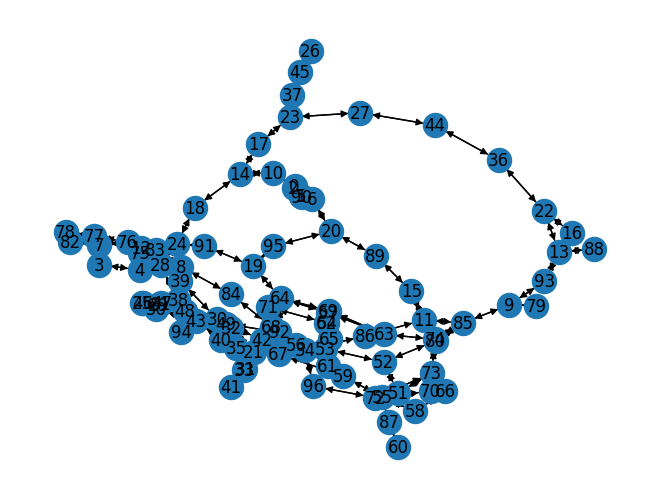

In [76]:
_, val_loader, test_loader = create_dataloaders()
for epoch in range(120, 121):

    generator.load_state_dict(torch.load(f"egnn/generator_{epoch}.pt"))
    discriminator.load_state_dict(torch.load(f"egnn/discriminator_{epoch}.pt"))

    with torch.no_grad():
        generator.eval()
        discriminator.eval()
        scores = []
        real_scores = []
        for batch in tqdm(test_loader, disable=True):
            batch = batch.to(device)
            output = forward(batch, train=True)
            real_pos = canonicalizer(batch.target_pos, batch.apsp_attr, batch.perm_index, batch.batch)
            real_score = evaluate(real_pos, batch)
            real_scores += real_score.tolist()
            scores += output['fake_score'].tolist()
            fake_logits = output['fake_logits']
            real_logits = output['real_logits']
            visualization_batch(batch, output['real_pos'], method='pmds')
            visualization_batch(batch, output['fake_pos'], method='with_egnn')
            break

    print(f'[Epoch {epoch}] Test Score:\t{np.mean(scores)}, Real Score: \t{np.mean(real_scores)}')
    print(f'[Epoch {epoch}] fake_logits:\t{np.mean(fake_logits.tolist())}, real_logits:\t{np.mean(real_logits.tolist())}')

Graph saved to visualization/pmds_after_rotate/graph_epoch_0_batch_0_graph_0.png
Graph saved to visualization/with_egnn_after_rotate/graph_epoch_0_batch_0_graph_0.png
[Epoch 120] Test Score:	594.05977165699, Real Score: 	608.0192096605897
[Epoch 120] fake_logits:	139.0774956047535, real_logits:	132.41612173616886


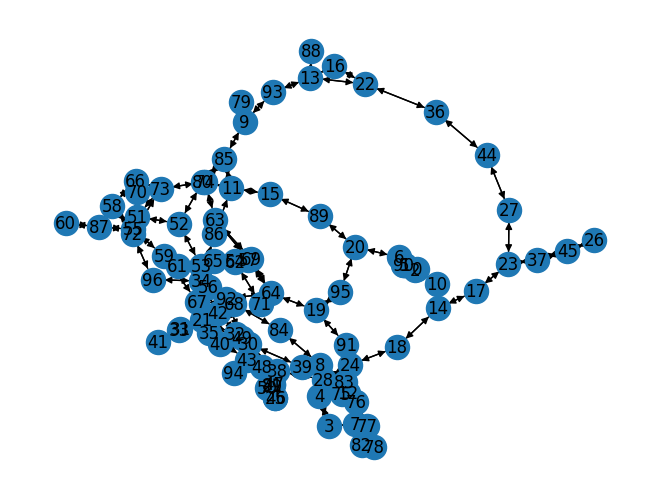

In [80]:
## After rotation
for epoch in range(120, 121):

    generator.load_state_dict(torch.load(f"egnn/generator_{epoch}.pt"))
    discriminator.load_state_dict(torch.load(f"egnn/discriminator_{epoch}.pt"))

    with torch.no_grad():
        generator.eval()
        discriminator.eval()
        scores = []
        real_scores = []
        for batch in tqdm(test_loader, disable=True):
            batch = batch.to(device)
            batch.target_pos = NormalizeRotation(base_angle=0.9)(batch.target_pos, batch.apsp_attr, batch.perm_index, batch.batch)
            output = forward(batch, train=True, rotation = True)
            real_pos = canonicalizer(batch.target_pos, batch.apsp_attr, batch.perm_index, batch.batch)
            real_score = evaluate(real_pos, batch)
            real_scores += real_score.tolist()
            scores += output['fake_score'].tolist()
            fake_logits = output['fake_logits']
            real_logits = output['real_logits']
            # output['fake_pos'] = NormalizeRotation(base_angle=0.3)(output['fake_pos'], batch.apsp_attr, batch.perm_index, batch.batch)
            visualization_batch(batch, output['real_pos'], method='pmds_after_rotate')
            visualization_batch(batch, output['fake_pos'], method='with_egnn_after_rotate')
            break

    print(f'[Epoch {epoch}] Test Score:\t{np.mean(scores)}, Real Score: \t{np.mean(real_scores)}')
    print(f'[Epoch {epoch}] fake_logits:\t{np.mean(fake_logits.tolist())}, real_logits:\t{np.mean(real_logits.tolist())}')